# Hyperparameter tune VIT model + Data Augementation

In [27]:
import os
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from shapely.geometry import MultiPolygon, Polygon
import shapely
from shapely import wkt

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torch import tensor

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.functional import multiclass_precision, multiclass_f1_score, multiclass_recall, multiclass_accuracy


import cv2
from PIL import Image
from transformers import ViTModel, ViTImageProcessor, ViTForImageClassification
from timm import create_model

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler


from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
import shutil
from torch import tensor

### Setup Current Directory

In [5]:
print("Current Path : ", os.getcwd())
os.chdir('../..')

Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/src/04_models


In [6]:
ROOT_DIR = os.getcwd()
print("Root Project Path : ", ROOT_DIR)
ROOT_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'xview_building_damage')
print("Root Data Path : ", ROOT_DATA_DIR)
TRAIN_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'train')
print("Train Data Path : ", TRAIN_DATA_DIR)
CHALLENGE_DIR = os.path.join(ROOT_DATA_DIR, 'challenge')
TRAIN_DIR=os.path.join(CHALLENGE_DIR, 'train')
HOLD_DIR=os.path.join(CHALLENGE_DIR, 'hold')
TEST_DIR=os.path.join(CHALLENGE_DIR, 'test')

Root Project Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio
Root Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage
Train Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train


### Preprocess the data with cropped images

In [7]:
train_data_wo_pre = pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv', 'train_4_classes_post_micheal.csv'))
valid_data_wo_pre = pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv', 'hold_4_classes_post_micheal.csv'))
test_data_wo_pre = pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv', 'test_4_classes_post_micheal.csv'))

In [9]:
def get_bounds_tp(image_wkt):
    bounds = wkt.loads(image_wkt).bounds
    return (bounds[0], bounds[1], bounds[2], bounds[3]) ## 

In [58]:
def crop_save_masked_images(data_split_dir, meta_df, crop_output_dir_name = 'img_mask_overlay_crop', disaster_name = 'hurricane-michael'):
    print("Starting Cropping the images")
    for idx, file_name in enumerate(meta_df['mask_file_names']):
        img = Image.open(os.path.join(data_split_dir, 'disaster', disaster_name,'img_mask_overlay', file_name))
        minx, miny, maxx, maxy = get_bounds_tp(meta_df.iloc[idx]['image_polygon'])
        cropped_img=img.crop((minx-5, miny-5, maxx+5, maxy+5))
        cropped_img.save(os.path.join(data_split_dir, 'disaster', disaster_name, crop_output_dir_name, file_name))
    print("Finished Cropping the images")

In [59]:
crop_save_masked_images(TRAIN_DIR, train_data_wo_pre)

Starting Cropping the images
Finished Cropping the images


In [60]:
crop_save_masked_images(HOLD_DIR, valid_data_wo_pre)

Starting Cropping the images
Finished Cropping the images


In [61]:
crop_save_masked_images(TEST_DIR, test_data_wo_pre)

Starting Cropping the images
Finished Cropping the images


In [63]:
def sort_masks_by_class(top_dir, meta_df, disaster_name='hurricane-michael', post=True):
    root_path=os.path.join(top_dir, 'disaster', disaster_name)
    disas_post_mask= os.path.join(root_path,'img_mask_overlay_crop') #source
    print("Source root : ", disas_post_mask)
    disas_class_path=os.path.join(root_path, 'img_mask_ov_crop_class')
    print("Destination root : ", disas_class_path)
    
    df = meta_df[meta_df['is_post_image'] == True]
    
    #    df = meta_df[meta_df['is_pre_image'] != post]
    print("Started moving the mask files to class folder for ", disaster_name)
    for idx, file_name in enumerate(df['mask_file_names']):
        source = os.path.join(disas_post_mask, df.iloc[idx]['mask_file_names'])
        destination = os.path.join(disas_class_path, df.iloc[idx]['damage'])
        if os.path.exists(destination):
            pass
        else:
            print( "Creating dir for " , df.iloc[idx]['damage'])
            os.mkdir(destination)
        
        if os.path.exists(source):
            shutil.copy(source, destination)
    print("Finshed moving the mask files to class folder for ", disaster_name)

In [64]:
sort_masks_by_class(TRAIN_DIR , train_data_wo_pre , 'hurricane-michael')

Source root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/train/disaster/hurricane-michael/img_mask_overlay_crop
Destination root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/train/disaster/hurricane-michael/img_mask_ov_crop_class
Started moving the mask files to class folder for  hurricane-michael
Finshed moving the mask files to class folder for  hurricane-michael


In [65]:
sort_masks_by_class(HOLD_DIR , valid_data_wo_pre , 'hurricane-michael')

Source root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/hold/disaster/hurricane-michael/img_mask_overlay_crop
Destination root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/hold/disaster/hurricane-michael/img_mask_ov_crop_class
Started moving the mask files to class folder for  hurricane-michael
Finshed moving the mask files to class folder for  hurricane-michael


In [66]:
sort_masks_by_class(TEST_DIR , test_data_wo_pre , 'hurricane-michael')

Source root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/test/disaster/hurricane-michael/img_mask_overlay_crop
Destination root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/test/disaster/hurricane-michael/img_mask_ov_crop_class
Started moving the mask files to class folder for  hurricane-michael
Finshed moving the mask files to class folder for  hurricane-michael


### Load the data

In [91]:
def get_img_class_dir(disaster_name, dataSplit, ROOT_DIR, class_dir='img_mask_ov_class'):   
 root_path=os.path.join(ROOT_DIR, 'disaster', disaster_name)
 DIR = os.path.join(root_path, class_dir)
 return DIR

In [77]:
def get_label_stats(data_loader):
    labels = [labels for i, (images, labels) in enumerate(data_loader)]
    labels = torch.cat((labels), 0)
    labels_count = labels.unique(return_counts=True)
    
    print('The number of samples per classes in training dataset:\n')
    for label, count in zip(labels_count[0], labels_count[1]):
        print('\t {}: {}'.format(label, count))
    return labels, labels_count

In [73]:
train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

valid_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

test_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [74]:
train_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'train', TRAIN_DIR, 'img_mask_ov_crop_class'), transform=train_transform)
valid_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'hold', HOLD_DIR, 'img_mask_ov_crop_class'), transform=valid_transform)
test_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'test', TEST_DIR, 'img_mask_ov_crop_class'), transform=test_transform)
print("Train set records : ", len(train_dataset))
print("Validation set records : ", len(valid_dataset))
print("Test set records : ", len(test_dataset))
print("================================================")
print(f"Train data:\n{train_dataset}")
print(f"Validation data:\n{valid_dataset}")
print(f"Test data:\n{test_dataset}")

Train set records :  22454
Validation set records :  7072
Test set records :  5602
Train data:
Dataset ImageFolder
    Number of datapoints: 22454
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/train/disaster/hurricane-michael/img_mask_ov_crop_class
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               RandomAutocontrast(p=0.5)
               ToTensor()
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 7072
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/hold/disaster/hurricane-michael/img_mask_ov_crop_class
    StandardTransform
Transform: Compose(
 

In [75]:
class_names = train_dataset.classes
print("class_names ",class_names)

class_dict = train_dataset.class_to_idx
print("class_dict ",class_dict)

class_names  ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
class_dict  {'destroyed': 0, 'major-damage': 1, 'minor-damage': 2, 'no-damage': 3}


In [76]:
trainset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset))))
testset = torch.utils.data.Subset(test_dataset, list(range(len(test_dataset))))
validset = torch.utils.data.Subset(valid_dataset, list(range(len(valid_dataset))))

In [78]:
batch_size = 128

# prepare data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=2)
valid_loader = DataLoader(validset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=2)
class_dict

{'destroyed': 0, 'major-damage': 1, 'minor-damage': 2, 'no-damage': 3}

In [80]:
train_labels, train_labels_count = get_label_stats(train_loader)

The number of samples per classes in training dataset:

	 0: 757
	 1: 1902
	 2: 5207
	 3: 14588


In [81]:
valid_labels, valid_labels_count = get_label_stats(valid_loader)

The number of samples per classes in training dataset:

	 0: 285
	 1: 608
	 2: 1722
	 3: 4457


In [82]:
test_labels, test_labels_count = get_label_stats(test_loader)

The number of samples per classes in training dataset:

	 0: 183
	 1: 409
	 2: 1363
	 3: 3647


#### Class Imbalance Correction

In [83]:
def get_class_weights(labels):
    class_counts = np.bincount(labels)
    num_classes = len(class_counts)
    total_samples = len(labels)
    
    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    
    return class_weights

In [84]:
class_weights=get_class_weights(train_labels)
class_weights

[29.661822985468955, 11.80546792849632, 4.312271941617054, 1.5392103098437073]

In [85]:
class_weights = torch.tensor(class_weights, dtype=torch.float32).to('cpu')
# balanced sampler
weights = class_weights[train_labels]
ws = WeightedRandomSampler(weights, len(weights), replacement=True)
ws

In [86]:
train_loader_ws = DataLoader(trainset, batch_size=batch_size, sampler=ws , num_workers=2)

In [87]:
train_labels_ws, train_labels_count_ws = get_label_stats(train_loader_ws)

The number of samples per classes in training dataset:

	 0: 5588
	 1: 5547
	 2: 5528
	 3: 5791


### Model Training

In [79]:
def get_metrics(preds_list, target_list, num_classes = 4 ):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    
    accuracy = multiclass_accuracy(pred_ts, target_ts, num_classes=4)
    
    f1_score = multiclass_f1_score(pred_ts, target_ts, num_classes=4, average="weighted")
    
    precision = multiclass_precision(pred_ts, target_ts, num_classes=4, average="weighted")
    recall = multiclass_recall(pred_ts, target_ts, num_classes=4, average="weighted")
    
    print("Accuracy :", accuracy)
    print("F1-score : ", f1_score)
    print("Precision : ", precision)
    print("Recall : ", recall)

In [101]:
model_name = "vit_base_patch16_224"
def setup_device():
    device = 'cpu' 
    if torch.cuda.is_available(): 
     device='cuda'
    elif torch.backends.mps.is_available():
     device = 'mps' 
    
    print("device = ", device)
    return device

In [100]:
def get_vit_model():
    vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
    print("=============================== Model heads ==========================")
    print(vision_transformer.heads)
    # fine-tune with dataset

    # change the number of output classes
    vision_transformer.heads = nn.Linear(in_features=768, out_features=len(class_names), bias=True)
    
    # freeze the parameters except the last linear layer
    #
    # freeze weights
    for p in vision_transformer.parameters():
        p.requires_grad = False
    
    # unfreeze weights of classification head to train
    for p in vision_transformer.heads.parameters():
        p.requires_grad = True

    print("=============================== Model Layers ==========================")
    for layer_name, p in vision_transformer.named_parameters():
        print('Layer Name: {}, Frozen: {}'.format(layer_name, not p.requires_grad))
        print()

    return vision_transformer

In [137]:
def calculate_weight_decay(batch, train_data_len, nepoches, lambda_norm):
    return lambda_norm * math.sqrt((batch/(train_data_len * nepoches)))

In [ ]:
def focal_loss(ce_loss, alpha =1 ,gamma =2):
    pt = torch.exp(-ce_loss)
    focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean()
    return focal_loss;

In [126]:
def plot_losses(train_loss_list, valid_loss_list, n_epoch):
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    # plot losses
    x = list(range(1, n_epoch + 1))
    plt.plot(x, train_loss_list, color ="blue", label='Train')
    plt.plot(x, valid_loss_list, color="orange", label='Validation')
    plt.legend(loc="upper right")
    plt.xticks(x)
    
    plt.show()

In [133]:
def accuracy_per_class(class_correct, class_total, class_names, accuracy ):
    n_class = len(class_names)

    class_accuracy = class_correct / class_total

    print('Test Accuracy of Classes')
    print()
    
    for c in range(n_class):
        print('{}\t: {}% \t ({}/{})'.format(class_names[c],
                                    int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )
    
    print()
    print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                               int(np.sum(class_correct)), int(np.sum(class_total)) ))
    

In [134]:
def train_eval_model(device, optimizer, criterion ,train_on_gpu, class_weights ,model=vision_transformer,  n_epoch = 15, data = train_loader_ws):
    
    train_loss_list, valid_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        model.to(device)
    
    # prepare model for training
    model.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
    
        # get batch data
        for i, (images, targets) in enumerate(data):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer.zero_grad()
    
            # feedforward data
            outputs = model(images)
    
            # calculate loss
            loss = criterion(outputs, targets)
    
            # backward pass, calculate gradients
            loss.backward()
    
            # update weights
            optimizer.step()
    
            # track loss
            train_loss += loss.item()
    
        # set model to evaluation mode
        model.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = model(images)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
    
        # set model back to training mode
        model.train()
    
        # get average loss values
        train_loss = train_loss / len(data)
        valid_loss = valid_loss / len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        # output training statistics for epoch
        print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format( (e+1), train_loss, valid_loss))
    
    
    plot_losses(train_loss_list, valid_loss_list, n_epoch)
    
    # prepare model for evaluation
    model.eval()
    
    class_weights = class_weights.to('cpu')
    preds_list = []
    target_list = []
    output_list = []
    
    test_loss = 0.0
    accuracy = 0
    
    # number of classes
    n_class = len(class_names)
    
    class_correct = np.zeros(n_class)
    class_total = np.zeros(n_class)
    
    # move model back to cpu
    model = model.to('cpu')
    
    # test model
    for images, targets in test_loader:
    
        # get outputs
        outputs = model(images)
    
        # calculate loss
        loss = criterion(outputs, targets)
    
        # track loss
        test_loss += loss.item()
    
        # get predictions from probabilities
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    
        target_list.extend(targets)
        output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
        preds_list.extend(preds)
    
        # get correct predictions
        correct_preds = (preds == targets).type(torch.FloatTensor)
    
        # calculate and accumulate accuracy
        accuracy += torch.mean(correct_preds).item() * 100
    
        # calculate test accuracy for each class
        for c in range(n_class):
    
            targets = targets.to('cpu')
    
            class_total[c] += (targets == c).sum()
            class_correct[c] += ((correct_preds) * (targets == c)).sum()
    
    # get average accuracy
    accuracy = accuracy / len(test_loader)
    
    # get average loss
    test_loss = test_loss / len(test_loader)
    
    # output test loss statistics
    print('Test Loss: {:.6f}'.format(test_loss))
    
    accuracy_per_class(class_correct, class_total, class_names, accuracy)
    
    get_metrics(preds_list, target_list)

### Model Training Parameters

In [148]:
criterion = nn.CrossEntropyLoss()

#criterion = FocalLoss(alpha=class_weights, gamma=2)
# define optimizer
lrs = [0.00001, 0.0001, 0.005, 0.001, 0.01, 0.1, 0.2, 0.5]
epoches = [5, 10, 15, 30, 50, 100, 150]

optimizer_0 = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)
optimizer_1 = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.001)
optimizer_2 = optim.SGD(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)
optimizer_3 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.001,  weight_decay=0.1)
optimizer_4 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0001,  weight_decay=0.1, amsgrad=True)
optimizer_5 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0001,  weight_decay=0.1,betas= (0.9,0.999), amsgrad=True)

### Sample Training

In [135]:
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[0]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[1],  weight_decay=0.1)
train_on_gpu = torch.backends.mps.is_available()

device =  mps
=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encode

Device available :  mps
Epoch: 1 	 Training Loss: 1.285090 	 Validation Loss: 1.141639
Epoch: 2 	 Training Loss: 1.162877 	 Validation Loss: 1.092519
Epoch: 3 	 Training Loss: 1.114243 	 Validation Loss: 1.046707
Epoch: 4 	 Training Loss: 1.083722 	 Validation Loss: 1.025652
Epoch: 5 	 Training Loss: 1.067583 	 Validation Loss: 1.027247


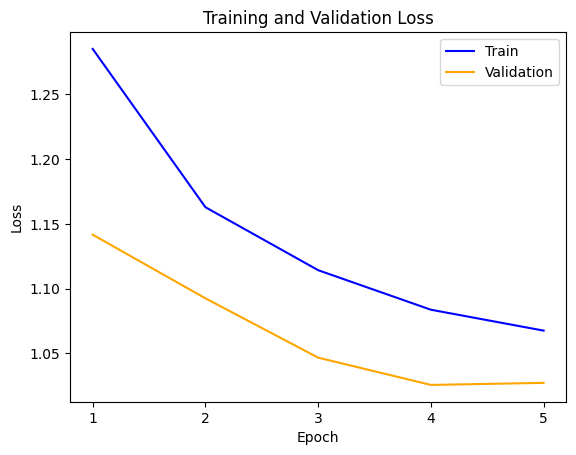

Test Loss: 1.031427
Test Accuracy of Classes

destroyed	: 64% 	 (118/183)
major-damage	: 51% 	 (211/409)
minor-damage	: 31% 	 (424/1363)
no-damage	: 68% 	 (2508/3647)

Test Accuracy of Dataset: 	 58% 	 (3261/5602)
Accuracy : tensor(0.5821)
F1-score :  tensor(0.6160)
Precision :  tensor(0.6833)
Recall :  tensor(0.5821)


In [136]:
train_eval_model(device, optimizer, criterion ,train_on_gpu,class_weights, vision_transformer,  epoch, train_loader_ws)

### Configuration 2

In [139]:
lambda_norm = [ 0.025, 0.035, 0.045, 0.05]
lambda_wd = calculate_weight_decay(batch_size, len(train_loader_ws), epoches[2], lambda_norm[0])
lambda_wd

0.005504818825631803

device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[2]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[1],  weight_decay=lambda_wd)
train_on_gpu = torch.backends.mps.is_available()

Device available :  mps
Epoch: 1 	 Training Loss: 1.288735 	 Validation Loss: 1.156432
Epoch: 2 	 Training Loss: 1.165801 	 Validation Loss: 1.086212
Epoch: 3 	 Training Loss: 1.116074 	 Validation Loss: 1.026275
Epoch: 4 	 Training Loss: 1.084625 	 Validation Loss: 1.034076
Epoch: 5 	 Training Loss: 1.063462 	 Validation Loss: 1.003798
Epoch: 6 	 Training Loss: 1.049786 	 Validation Loss: 1.007047
Epoch: 7 	 Training Loss: 1.040074 	 Validation Loss: 1.018951
Epoch: 8 	 Training Loss: 1.022413 	 Validation Loss: 0.986450
Epoch: 9 	 Training Loss: 1.018573 	 Validation Loss: 0.971525
Epoch: 10 	 Training Loss: 1.021759 	 Validation Loss: 0.972415
Epoch: 11 	 Training Loss: 1.011886 	 Validation Loss: 1.012361
Epoch: 12 	 Training Loss: 1.002407 	 Validation Loss: 0.999928
Epoch: 13 	 Training Loss: 1.001163 	 Validation Loss: 0.961276
Epoch: 14 	 Training Loss: 0.984738 	 Validation Loss: 0.995423
Epoch: 15 	 Training Loss: 0.991202 	 Validation Loss: 0.972287


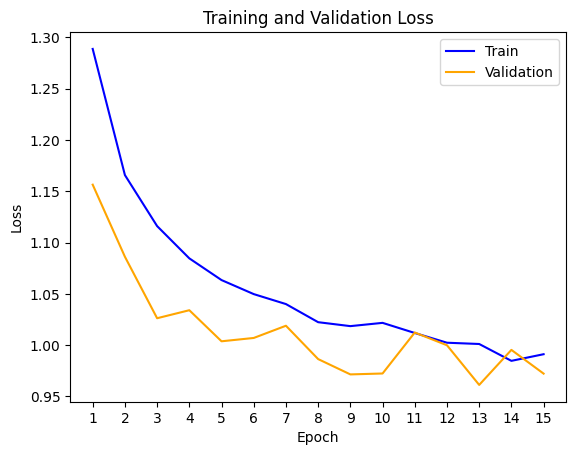

Test Loss: 0.970547
Test Accuracy of Classes

destroyed	: 71% 	 (131/183)
major-damage	: 50% 	 (208/409)
minor-damage	: 31% 	 (431/1363)
no-damage	: 70% 	 (2578/3647)

Test Accuracy of Dataset: 	 59% 	 (3348/5602)
Accuracy : tensor(0.5976)
F1-score :  tensor(0.6278)
Precision :  tensor(0.6910)
Recall :  tensor(0.5976)


In [141]:
train_eval_model(device, optimizer, criterion ,train_on_gpu, class_weights, vision_transformer,  epoch, train_loader_ws)

### Configuration 3

In [144]:
lambda_wd = calculate_weight_decay(batch_size, len(train_loader_ws), epoches[2], lambda_norm[3])
print(" Lambda : ", lambda_wd)
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[2]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[1],  weight_decay=lambda_wd)
train_on_gpu = torch.backends.mps.is_available()

 Lambda :  0.011009637651263606
device =  mps
=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

L

Device available :  mps
Epoch: 1 	 Training Loss: 1.296221 	 Validation Loss: 1.179669
Epoch: 2 	 Training Loss: 1.168715 	 Validation Loss: 1.086396
Epoch: 3 	 Training Loss: 1.116534 	 Validation Loss: 1.043555
Epoch: 4 	 Training Loss: 1.091954 	 Validation Loss: 1.042407
Epoch: 5 	 Training Loss: 1.063100 	 Validation Loss: 1.034446
Epoch: 6 	 Training Loss: 1.056276 	 Validation Loss: 0.992288
Epoch: 7 	 Training Loss: 1.042656 	 Validation Loss: 0.989275
Epoch: 8 	 Training Loss: 1.029436 	 Validation Loss: 1.005832
Epoch: 9 	 Training Loss: 1.020167 	 Validation Loss: 1.018831
Epoch: 10 	 Training Loss: 1.017164 	 Validation Loss: 0.985310
Epoch: 11 	 Training Loss: 1.008211 	 Validation Loss: 0.967928
Epoch: 12 	 Training Loss: 1.004065 	 Validation Loss: 0.978641
Epoch: 13 	 Training Loss: 1.001270 	 Validation Loss: 1.000466
Epoch: 14 	 Training Loss: 0.998556 	 Validation Loss: 0.970011
Epoch: 15 	 Training Loss: 0.983774 	 Validation Loss: 0.975276


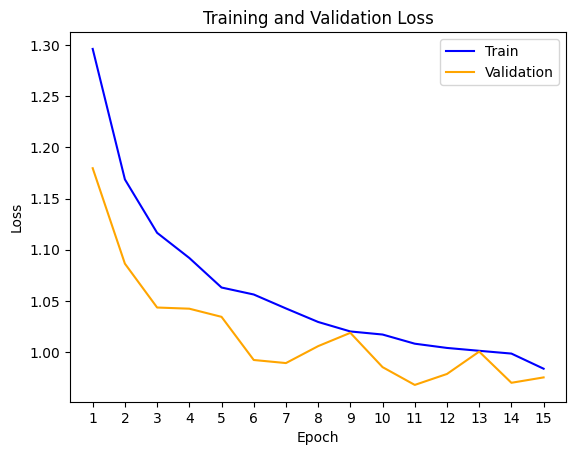

Test Loss: 0.977909
Test Accuracy of Classes

destroyed	: 68% 	 (126/183)
major-damage	: 52% 	 (216/409)
minor-damage	: 35% 	 (484/1363)
no-damage	: 68% 	 (2505/3647)

Test Accuracy of Dataset: 	 59% 	 (3331/5602)
Accuracy : tensor(0.5946)
F1-score :  tensor(0.6273)
Precision :  tensor(0.6910)
Recall :  tensor(0.5946)


In [145]:
train_eval_model(device, optimizer, criterion ,train_on_gpu, class_weights, vision_transformer,  epoch, train_loader_ws)

### Configuration 4

In [151]:
lambda_wd = calculate_weight_decay(batch_size, len(train_loader_ws), epoches[2], lambda_norm[3])
print(" Lambda : ", lambda_wd)
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[3]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[3],  weight_decay=lambda_wd)
train_on_gpu = torch.backends.mps.is_available()

 Lambda :  0.011009637651263606
device =  mps
=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

L

Device available :  mps
Epoch: 1 	 Training Loss: 1.091125 	 Validation Loss: 0.989872
Epoch: 2 	 Training Loss: 0.992144 	 Validation Loss: 0.949009
Epoch: 3 	 Training Loss: 0.971847 	 Validation Loss: 0.971500
Epoch: 4 	 Training Loss: 0.958979 	 Validation Loss: 1.008936
Epoch: 5 	 Training Loss: 0.950020 	 Validation Loss: 0.993240
Epoch: 6 	 Training Loss: 0.937742 	 Validation Loss: 0.972382
Epoch: 7 	 Training Loss: 0.936724 	 Validation Loss: 0.925007
Epoch: 8 	 Training Loss: 0.930389 	 Validation Loss: 0.893564
Epoch: 9 	 Training Loss: 0.913500 	 Validation Loss: 0.913397
Epoch: 10 	 Training Loss: 0.905897 	 Validation Loss: 0.963872
Epoch: 11 	 Training Loss: 0.911730 	 Validation Loss: 0.868752
Epoch: 12 	 Training Loss: 0.906427 	 Validation Loss: 0.922727
Epoch: 13 	 Training Loss: 0.900183 	 Validation Loss: 0.861674
Epoch: 14 	 Training Loss: 0.907937 	 Validation Loss: 0.926045
Epoch: 15 	 Training Loss: 0.893973 	 Validation Loss: 0.938047
Epoch: 16 	 Training Loss

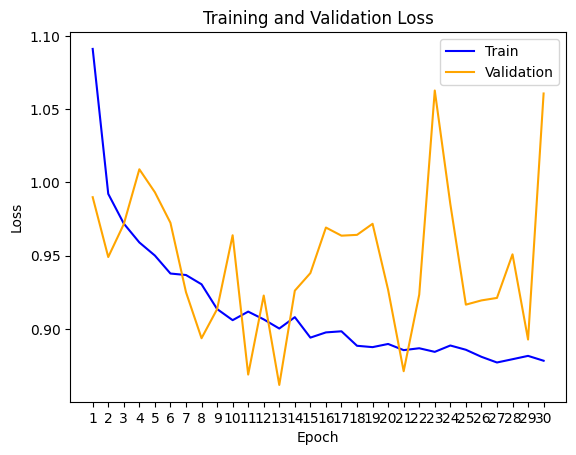

Test Loss: 1.053053
Test Accuracy of Classes

destroyed	: 81% 	 (149/183)
major-damage	: 58% 	 (239/409)
minor-damage	: 33% 	 (451/1363)
no-damage	: 62% 	 (2292/3647)

Test Accuracy of Dataset: 	 55% 	 (3131/5602)
Accuracy : tensor(0.5589)
F1-score :  tensor(0.6036)
Precision :  tensor(0.7036)
Recall :  tensor(0.5589)


In [147]:
train_eval_model(device, optimizer, criterion ,train_on_gpu, class_weights, vision_transformer,  epoch, train_loader_ws)

### Configuration 5

In [152]:
lambda_wd = calculate_weight_decay(batch_size, len(train_loader_ws), epoches[2], lambda_norm[3])
print(" Lambda : ", lambda_wd)
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[3]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[1],  weight_decay=lambda_wd)
train_on_gpu = torch.backends.mps.is_available()

 Lambda :  0.011009637651263606
device =  mps
=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

L

Device available :  mps
Epoch: 1 	 Training Loss: 1.278490 	 Validation Loss: 1.134938
Epoch: 2 	 Training Loss: 1.165027 	 Validation Loss: 1.084361
Epoch: 3 	 Training Loss: 1.114402 	 Validation Loss: 1.023333
Epoch: 4 	 Training Loss: 1.084750 	 Validation Loss: 1.049248
Epoch: 5 	 Training Loss: 1.066393 	 Validation Loss: 1.014848
Epoch: 6 	 Training Loss: 1.048819 	 Validation Loss: 1.020521
Epoch: 7 	 Training Loss: 1.040382 	 Validation Loss: 1.028860
Epoch: 8 	 Training Loss: 1.027018 	 Validation Loss: 1.008426
Epoch: 9 	 Training Loss: 1.024063 	 Validation Loss: 0.970349
Epoch: 10 	 Training Loss: 1.014898 	 Validation Loss: 0.994659
Epoch: 11 	 Training Loss: 1.011391 	 Validation Loss: 0.997614
Epoch: 12 	 Training Loss: 1.005012 	 Validation Loss: 0.996071
Epoch: 13 	 Training Loss: 0.991886 	 Validation Loss: 0.977790
Epoch: 14 	 Training Loss: 0.994977 	 Validation Loss: 0.970866
Epoch: 15 	 Training Loss: 0.981530 	 Validation Loss: 0.972025
Epoch: 16 	 Training Loss

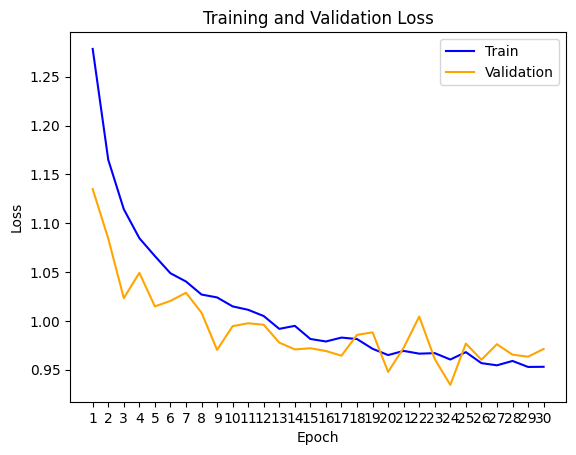

Test Loss: 0.968473
Test Accuracy of Classes

destroyed	: 72% 	 (132/183)
major-damage	: 56% 	 (231/409)
minor-damage	: 35% 	 (482/1363)
no-damage	: 69% 	 (2530/3647)

Test Accuracy of Dataset: 	 60% 	 (3375/5602)
Accuracy : tensor(0.6025)
F1-score :  tensor(0.6350)
Precision :  tensor(0.7035)
Recall :  tensor(0.6025)


In [153]:
train_eval_model(device, optimizer, criterion ,train_on_gpu, class_weights, vision_transformer,  epoch, train_loader_ws)